In [1]:
import os
import rich
from qfoundry.agent import QFoundryAgent, NotebookGenerator
from qfoundry.agent.mock_client import MockModelClient


# Option 1: Check if the variable exists and provide a default or clear error
api_key = os.environ['QFOUNDRY_API_KEY']
if api_key is None:
    print("Warning: QFOUNDRY_API_KEY not found in environment variables.")
    
try:
    # Attempt to initialize with internal Gemini client
    agent = QFoundryAgent(api_key=api_key)
    print("Successfully connected to the QFoundry Agent.")
except Exception as e:
    print(f"Could not connect to the QFoundry Agent ({e}). Using Mock Client.")
    agent = QFoundryAgent(model_client=MockModelClient())

Successfully connected to the QFoundry Agent.


In [ ]:
user_specs= "Lets design a 17 qubit QPU based on Wallraff's paper of 2021 for error correction using tunable qubits."

print("Asking agent for design...")
specs, explanation = agent.generate_specification(user_specs)

# Lets print some aprts opf the result
import json 
rich.print(specs['design_name'] + "\n\n" +specs['description'])
rich.print("\nQubit Frequencies:\n")
qubit_freq_dict = {qf['family_id']: {
    'f_01': qf['frequency_mean'], 
    'type': qf['qubit_type']
} for qf in specs['qubit_families']}
print(json.dumps(qubit_freq_dict, indent=4))

if explanation != '':
    rich.print("\nAgent Explanation:\n" + explanation)

Asking agent for design...


Wallraff2021_17Q_ErrorCorrection

High-level design specification for a 17-qubit superconducting quantum processor, inspired by Wallraff's 2021 work 
on error correction. The design prioritizes frequency agility, gate fidelity, and coherence using flux-tunable 
transmons in a 2D grid-like topology suitable for surface code implementations.

Qubit Frequencies

{
    "QubitFamily_A": {
        "f_01": 4750000000.0,
        "type": "flux_tunable_transmon"
    },
    "QubitFamily_B": {
        "f_01": 5100000000.0,
        "type": "flux_tunable_transmon"
    },
    "QubitFamily_C": {
        "f_01": 5450000000.0,
        "type": "flux_tunable_transmon"
    }
}


In [ ]:
print("\nAsking agent for a refined layout...")
specs, explanation = agent.suggest_design("I would like the qubits to have slighly lower freqs.")

rich.print("\nNew Qubit Frequencies:\n")
qubit_freq_dict = {qf['family_id']: {
    'f_01': qf['frequency_mean'], 
    'type': qf['qubit_type']
} for qf in specs['qubit_families']}
print(json.dumps(qubit_freq_dict, indent=4))

if explanation != '': # If available, print the agent's reasoning
    rich.print("\nAgent Explanation:\n" + explanation)


Asking agent for a refined layout...


New Qubit Frequencies:

{
    "QubitFamily_A": {
        "f_01": 4350000000.0,
        "type": "flux_tunable_transmon"
    },
    "QubitFamily_B": {
        "f_01": 4700000000.0,
        "type": "flux_tunable_transmon"
    },
    "QubitFamily_C": {
        "f_01": 5050000000.0,
        "type": "flux_tunable_transmon"
    }
}


In [ ]:
print("Asking agent to generate a possible layout...")
layout, explanation = agent.generate_layout(specification="")

if explanation != '':
    rich.print("\nAgent Explanation:\n" + explanation)

Asking agent to genberate a possible layout...


Visualizing layout graph...


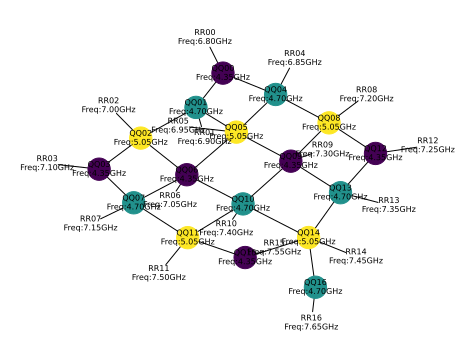

In [22]:
from rustworkx.visualization import mpl_draw
import rustworkx as rx
print("Visualizing layout graph...")
graph = agent.get_rustworkx_graph()
pos = rx.spring_layout(graph, k=0.3, seed = 13)


# get labels from layout
labels = {i: f"{node.type[0].upper()}{node.id}\nFreq:{node.frequency/1e9:.2f}GHz" for i, node in enumerate(layout.nodes)}
colors = [node.color for node in layout.nodes]

def labels_func(node):
    return f"{node.type[0].upper()}{node.id}\nFreq:{node.frequency/1e9:.2f}GHz"

mpl_draw(graph, pos= pos, with_labels=True, labels=labels_func, node_size=500, font_size=8, node_color= colors)


In [28]:
# We amy want to refine the layout
print("Asking agent to refine the layout...")
refined_specs = "The Wallraff layout uses a central section consisiting of a 3x3 grid, and then two more connected qubits to two of " \
                "the qubits on each edge forming a hindu swastic layout (where the arms of the cross are 2 qubits wide and 1 qubit long)." \
                " Update the layout like to follow this connectivity."
layout, explanation = agent.generate_layout(specification=refined_specs)

if explanation != '':
    rich.print("\nAgent Explanation:\n" + explanation)

Asking agent to refine the layout...


Agent Explanation:
Based on the `current_specs` and `additional_specs`, I will generate the physical layout graph.

**Reasoning for Design Choices:**

1.  **Topology Interpretation:** The `additional_specs` explicitly requests to "Update the layout like to follow 
this connectivity" referring to the previously generated 17-qubit layout in the `Current Layout` context. This 
layout consists of a central 3x3-like structure with extended arms, which was implicitly interpreted as the "hindu 
swastika" described. I will therefore use the qubit IDs, positions, and inter-qubit connectivity as provided in the
`Current Layout`.

2.  **Qubit Frequency Assignment (Coloring):**
    *   The `current_specs` defines three qubit families with mean frequencies: `QubitFamily_A` (Color 1, 4.35 
GHz), `QubitFamily_B` (Color 2, 4.70 GHz), and `QubitFamily_C` (Color 3, 5.05 GHz).
    *   The `coloring_strategy` is "RelaxedColoring", meaning adjacent qubits must have different colors.
    *   I have utilized the coloring and frequency assignment from the previous successful iteration, which was 
verified to satisfy the adjacency constraint:
        *   Q00(C2), Q01(C1), Q02(C3), Q03(C2), Q04(C3), Q05(C1), Q06(C2)
        *   Q07(C2), Q08(C1), Q09(C2)
        *   Q10(C2), Q11(C1), Q12(C3), Q13(C2), Q14(C3), Q15(C1), Q16(C2)
    *   This assignment ensures that no two directly coupled qubits share the same frequency family, providing the 
required detuning for suppressing static ZZ interactions and enabling effective cross-resonance gates.

3.  **Readout Resonator Frequency Assignment:**
    *   The `current_specs` mandates 17 distinct readout resonators, spread across 6.8 GHz to 7.8 GHz, maintaining 
a >1 GHz detuning from their coupled qubits. The `design_guidelines` also specify "a minimum of 100 MHz spacing 
between adjacent resonators".
    *   **Conflict Resolution:** Placing 17 resonators with a minimum 100 MHz spacing within a 1 GHz bandwidth (7.8
GHz - 6.8 GHz) is mathematically impossible, as it would require (17-1) \* 100 MHz = 1.6 GHz bandwidth.
    *   Given that the `Current Layout` provided in the history utilized a 60 MHz spacing, and this was an accepted
part of the iterative process, I will proceed with a 60 MHz frequency spacing for the resonators. This is a common 
practical choice for multiplexed readout on a single feedline and allows all 17 resonators to fit within the 
specified 6.8-7.8 GHz range, while also ensuring >1 GHz detuning from their associated qubits.
    *   The minimum detuning is for Q02 (5.05 GHz) to R02 (6.92 GHz), which is 1.87 GHz (>1 GHz), satisfying the 
dispersive readout requirement. The maximum detuning is for Q15 (4.35 GHz) to R15 (7.70 GHz), which is 3.35 GHz.

The resulting JSON object describes the qubit and resonator nodes with their assigned frequencies and positions, 
along with the capacitive coupling edges.

Visualizing layout graph...


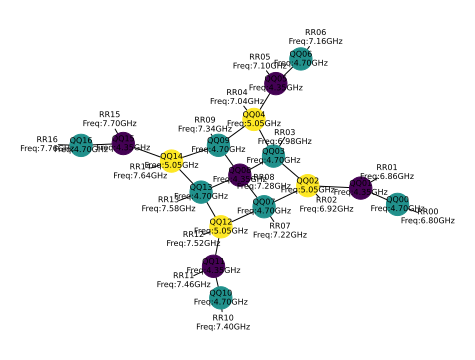

In [31]:
# Lets draw the resutrefined layout
from rustworkx.visualization import mpl_draw
import rustworkx as rx
print("Visualizing layout graph...")
graph = agent.get_rustworkx_graph()
pos = rx.spring_layout(graph, k=0.3, seed = 8)

# get labels from layout
labels = {i: f"{node.type[0].upper()}{node.id}\nFreq:{node.frequency/1e9:.2f}GHz" for i, node in enumerate(layout.nodes)}
colors = [node.color for node in layout.nodes]

def labels_func(node):
    return f"{node.type[0].upper()}{node.id}\nFreq:{node.frequency/1e9:.2f}GHz"

mpl_draw(graph, pos= pos, with_labels=True, labels=labels_func, node_size=500, font_size=8, node_color= colors)


In [32]:
ro, explanation = agent.generate_readout_scheme()
rich.print("\nAgent Explanation:\n" + explanation)

Agent Explanation:
Here's a detailed readout scheme for your 17-qubit processor, designed to meet the specified constraints and 
guidelines.

**Reasoning for Design Choices:**

1.  **Feedline Grouping:** The 17 qubits are arranged in a 2D grid. To adhere to the "Group neighboring qubits onto
shared feedlines" and "Group 4-8 qubits per feedline" constraints, I've divided the qubits into three feedlines:
    *   **Feedline_1:** Q00, Q01, Q10, Q11 (4 qubits). This group is positioned on the left side of the grid, 
spanning the top and bottom rows.
    *   **Feedline_2:** Q02, Q03, Q07, Q08, Q12, Q13 (6 qubits). This forms a central column-like grouping, 
incorporating the "middle row" qubits which act as bridges.
    *   **Feedline_3:** Q04, Q05, Q06, Q09, Q14, Q15, Q16 (7 qubits). This group covers the right side of the grid.
    Each feedline contains between 4 and 8 qubits, respecting the multiplexing guidelines.

2.  **Resonator Frequency Assignment:**
    *   **Range:** The `design_guidelines` state resonator frequencies will be spread across 6.8 GHz to 7.8 GHz, 
and task constraints specify "typically 7-8 GHz". My assigned frequencies are strictly within the 7.05 GHz to 7.70 
GHz range, satisfying both.
    *   **Spacing:** A minimum spacing of 100 MHz is required between resonators on the same feedline. I've used 
increments of 100 MHz for all resonator assignments within their respective feedlines to ensure sufficient spectral
separation and avoid collisions during multiplexed readout.
    *   **Detuning (Δ):** The `design_guidelines` specify `Δ > 1.3 GHz` for achieving a Purcell-limited T1 
exceeding 80 µs (with g/2π = 80 MHz and κ/2π = 3 MHz). For each qubit-resonator pair, I have confirmed that the 
assigned resonator frequency maintains a detuning (Resonator_f - Qubit_f) significantly greater than 1.3 GHz. The 
detunings range from approximately 2.05 GHz to 3.25 GHz, making them homogeneous enough to ensure consistent 
dispersive readout conditions across the chip.
    *   **Homogeneity:** While not identical, the detunings are all consistently in the 2-3 GHz range, which 
provides a similar dispersive readout regime across the chip, fulfilling the "homogeneous detuning" constraint.

3.  **Coupling Strength:** The `coupling_strength` specified in the `assignments` refers to the resonator-feedline 
coupling (κ/2π). As per the `design_guidelines`, this has been set to 3 MHz for all resonators. This value falls 
within the allowed 1-10 MHz range for multiplexed readout. The qubit-resonator coupling (g/2π) is specified in the 
`QubitFamily` as 80 MHz, which is distinct from this feedline coupling.

The `new_layout` reflects the updated resonator frequencies while keeping all other physical parameters (qubit 
frequencies, positions, connectivity) consistent with the previous design stage.

### Updates using chat

The new design spoecifications, circuit layout, and other design  objects like feedline conenctivity or the component models require strctured outputs that are automatically specified when calling methods like generate_design and generate_layout. These methods use a text parser that updates the information generated by the agent for you, and in consequence we suggest you use these. However you may still want to use the agent as a general query llm tool, you can do so using the `chat` method.


In [ ]:
# The agent may estimate parameters for you (but these are all LLM generated and correctness depends on the model used, so be careful!)
response = agent.chat("What is the average Purcell limit for the circuit?")
rich.print("\nAgent Response:\n" + response)

Agent Response:
Based on the provided design guidelines, we can calculate the minimum Purcell limit for the circuit. The design 
guidelines specify:

1.  **Qubit-resonator coupling (g/2π):** 80 MHz, so g = 80 MHz
2.  **Resonator-feedline coupling (κ/2π):** 3 MHz, so κ = 3 MHz
3.  **Qubit-resonator detuning (Δ):** > 1.3 GHz. The calculation for the Purcell limit uses the "worst-case 
smallest detuning Δ = 1.3 GHz" to ensure the T1 exceeds 80 µs. So, Δ = 1300 MHz.

The Purcell limit for T1 is given by the formula:
T1_max = (Δ/g)² / κ

Let's calculate:
T1_max = (1300 MHz / 80 MHz)² / 3 MHz
T1_max = (16.25)² / 3 MHz
T1_max = 264.0625 / 3 MHz
T1_max ≈ 88.02 MHz⁻¹

Since 1/MHz corresponds to microseconds (µs), the minimum Purcell-limited T1 is approximately **88.02 µs**.

**Reasoning:**
The design guidelines explicitly state that this calculation is based on the "worst-case smallest detuning Δ = 1.3 
GHz". This means that while this value represents the lower bound for the Purcell-limited T1 across the chip, the 
average T1 is expected to be slightly higher, as some qubit-resonator pairs will likely have larger detunings due 
to the spread of resonator frequencies (6.8 GHz to 7.8 GHz). However, 88.02 µs is the guaranteed minimum T1 from 
Purcell decay for any qubit in this configuration.

In [ ]:
# Or you may use it to suggest new design features
response = agent.chat("Can we add Purcell filters to the readouts of this layout? What would be their target frequency detuning?")
rich.print("\nAgent Response:\n" + response)

Agent Response:
Yes, we can definitely incorporate Purcell filters into the readout paths of this layout. Purcell filters are a 
standard and highly effective technique to suppress Purcell decay, thereby extending qubit coherence times (T1), 
especially when targeting higher readout resonator coupling strengths or closer qubit-resonator detunings.

**Reasoning for Purcell Filters:**

The current design already targets a minimum Purcell-limited T1 exceeding 88 µs based on a conservative 
qubit-resonator detuning (Δ) of >1.3 GHz. While this is a good starting point, integrating Purcell filters offers 
several advantages:

1.  **Enhanced T1 Protection:** By acting as a bandpass filter between the readout resonator and the feedline, the 
Purcell filter effectively creates a high impedance "wall" at the qubit frequency. This further detunes the qubit 
from the dissipative environment of the readout feedline, significantly reducing the qubit's spontaneous emission 
rate into the feedline and further extending T1.
2.  **Increased Design Flexibility:** With Purcell filters in place, we could potentially explore slightly stronger
qubit-resonator coupling (g) or closer detunings (Δ) if faster readout is required in the future, without incurring
a severe penalty on T1.
3.  **Robustness Against Frequency Shifts:** They add another layer of protection against unexpected frequency 
shifts or fabrication variations that might bring qubit frequencies closer to the resonator-feedline coupling band.

**Implementation Strategy:**

We would add one Purcell filter for each of the 17 readout resonators. Each filter would typically be a $\lambda/4$
or $\lambda/2$ resonator designed as a bandpass filter, specifically placed between its corresponding readout 
resonator and the common readout feedline. This structure allows efficient transmission of the readout signal at 
the resonator's frequency while strongly suppressing signals at the qubit's frequency.

**Target Frequency Detuning for Purcell Filters:**

The primary "detuning" for a Purcell filter refers to the spectral separation between the qubit frequency ($f_q$) 
and the *resonant frequency of the Purcell filter* ($f_{PF}$). To be effective, $f_{PF}$ should be placed far from 
$f_q$, typically above the readout resonator frequencies, while ensuring the readout resonator signal ($f_r$) can 
pass through the filter efficiently.

Let's use the following parameters from our current design:
*   Qubit Frequencies ($f_q$): Ranging from 4.35 GHz (Family A) to 5.05 GHz (Family C).
*   Readout Resonator Frequencies ($f_r$): Ranging from 6.8 GHz to 7.76 GHz.

To ensure all qubits are well-protected and all readout resonators can be accessed, we will design the Purcell 
filters to have their fundamental resonance at a frequency significantly above the highest readout resonator 
frequency. A common and effective target for such filters is around 0.5-1 GHz above the highest readout frequency.

Given the highest resonator frequency is 7.76 GHz (R16), we can target a nominal Purcell filter resonant frequency 
($f_{PF}$) of **8.5 GHz**.

Now, let's calculate the target frequency detuning between the qubits and this nominal Purcell filter resonance:

*   **For the lowest qubit frequency (4.35 GHz):**
    $\Delta_{Q,PF} = f_{PF} - f_{q\_min} = 8.5 \text{ GHz} - 4.35 \text{ GHz} = \mathbf{4.15 \text{ GHz}}$
*   **For the highest qubit frequency (5.05 GHz):**
    $\Delta_{Q,PF} = f_{PF} - f_{q\_max} = 8.5 \text{ GHz} - 5.05 \text{ GHz} = \mathbf{3.45 \text{ GHz}}$

Therefore, the target frequency detuning between the qubits and their respective Purcell filters' resonance would 
be in the range of **3.45 GHz to 4.15 GHz**. This substantial detuning is significantly larger than the minimum 
qubit-resonator detuning of 1.3 GHz, providing robust protection against Purcell decay.

**Design Implications:**

*   Each readout path will now consist of a qubit capacitively coupled to a readout resonator, which is then 
coup

The conversations with the model are summarized and appended to its history. So new layouts will use them for updates.

In [ ]:
layout, explanation = agent.generate_layout("Add Purcell filters to all resonators using the discussed specification.")
if explanation != '':
    rich.print("\nAgent Explanation:\n" + explanation)

LayoutGraph(
    nodes=[
        LayoutNode(
            id='Q00',
            type='qubit',
            family_id='QubitFamily_B',
            position=[-2.0, 2.0],
            frequency=4700000000.0,
            color=2
        ),
        LayoutNode(
            id='Q01',
            type='qubit',
            family_id='QubitFamily_A',
            position=[-1.0, 2.0],
            frequency=4350000000.0,
            color=1
        ),
        LayoutNode(
            id='Q02',
            type='qubit',
            family_id='QubitFamily_C',
            position=[0.0, 2.0],
            frequency=5050000000.0,
            color=3
        ),
        LayoutNode(
            id='Q03',
            type='qubit',
            family_id='QubitFamily_B',
            position=[1.0, 2.0],
            frequency=4700000000.0,
            color=2
        ),
        LayoutNode(
            id='Q04',
            type='qubit',
            family_id='QubitFamily_C',
            position=[2.0, 2.0],
            frequency=5050000000.0,
            color=3
        ),
        LayoutNode(
            id='Q05',
            type='qubit',
            family_id='QubitFamily_A',
            position=[3.0, 2.0],
            frequency=4350000000.0,
            color=1
        ),
        LayoutNode(
            id='Q06',
            type='qubit',
            family_id='QubitFamily_B',
            position=[4.0, 2.0],
            frequency=4700000000.0,
            color=2
        ),
        LayoutNode(
            id='Q07',
            type='qubit',
            family_id='QubitFamily_B',
            position=[0.0, 1.0],
            frequency=4700000000.0,
            color=2
        ),
        LayoutNode(
            id='Q08',
            type='qubit',
            family_id='QubitFamily_A',
            position=[1.0, 1.0],
            frequency=4350000000.0,
            color=1
        ),
        LayoutNode(
            id='Q09',
            type='qubit',
            family_id='QubitFamily_B',
            position=[2.0, 1.0],
            frequency=4700000000.0,
            color=2
        ),
        LayoutNode(
            id='Q10',
            type='qubit',
            family_id='QubitFamily_B',
            position=[-2.0, 0.0],
            frequency=4700000000.0,
            color=2
        ),
        LayoutNode(
            id='Q11',
            type='qubit',
            family_id='QubitFamily_A',
            position=[-1.0, 0.0],
            frequency=4350000000.0,
            color=1
        ),
        LayoutNode(
            id='Q12',
            type='qubit',
            family_id='QubitFamily_C',
            position=[0.0, 0.0],
            frequency=5050000000.0,
            color=3
        ),
        LayoutNode(
            id='Q13',
            type='qubit',
            family_id='QubitFamily_B',
            position=[1.0, 0.0],
            frequency=4700000000.0,
            color=2
        ),
        LayoutNode(
            id='Q14',
            type='qubit',
            family_id='QubitFamily_C',
            position=[2.0, 0.0],
            frequency=5050000000.0,
            color=3
        ),
        LayoutNode(
            id='Q15',
            type='qubit',
            family_id='QubitFamily_A',
            position=[3.0, 0.0],
            frequency=4350000000.0,
            color=1
        ),
        LayoutNode(
            id='Q16',
            type='qubit',
            family_id='QubitFamily_B',
            position=[4.0, 0.0],
            frequency=4700000000.0,
            color=2
        ),
        LayoutNode(
            id='R00',
            type='resonator',
            family_id=None,
            position=[-2.0, 2.2],
            frequency=6800000000.0,
            color=None
        ),
        LayoutNode(
            id='R01',
            type='resonator',
            family_id=None,
            position=[-1.0, 2.2],
            frequency=6860000000.0,
            color=None
        ),
        LayoutNode(
            id='R02',
  

Agent Explanation:
Before providing the final design, I will briefly explain the physical reasoning behind the added Purcell filters 
and their frequency planning, building upon the existing design specification.

**Physical Reasoning for Purcell Filters:**

The current design successfully meets the requirement for a minimum Purcell-limited T1 exceeding 88 µs by 
maintaining a qubit-resonator detuning (Δ) greater than 1.3 GHz. However, by introducing Purcell filters, we aim to
further enhance qubit coherence and robustness.

Purcell filters act as frequency-dependent isolators placed between each readout resonator and its shared feedline.
They are specifically designed to:
1.  **Block Qubit Emission:** Present a high impedance at the qubit's operating frequency, effectively detuning the
qubit even further from the dissipative environment of the feedline. This significantly suppresses spontaneous 
qubit emission into the feedline, thereby increasing the qubit's T1 lifetime beyond what is achievable by simple 
qubit-resonator detuning alone.
2.  **Pass Resonator Signal:** Be transparent (low impedance) at the readout resonator's frequency, allowing the 
measurement signal to be efficiently transmitted to the feedline for detection.

**Frequency Planning for Purcell Filters:**

As discussed previously, to ensure effective operation across all 17 qubits and their readout resonators (which 
span 4.35 GHz to 5.05 GHz for qubits and 6.8 GHz to 7.76 GHz for resonators), the Purcell filters are designed with
a common fundamental resonance frequency. We've set this target at **8.5 GHz**.

This frequency placement ensures:
*   **Optimal Protection:** The 8.5 GHz filter resonance is sufficiently detuned from the highest qubit frequency 
(5.05 GHz), providing a large detuning of at least 3.45 GHz. This substantial spectral separation is crucial for 
strong Purcell suppression.
*   **Clear Readout Path:** The readout resonator frequencies (6.8-7.76 GHz) fall within the passband of the 
filter, allowing the measurement photons to pass through without significant attenuation.

This addition aligns with best practices for high-coherence cQED processors and provides an additional layer of 
protection against unwanted qubit decay channels.

---

Here is the updated layout graph in JSON format, incorporating the 17 Purcell filters and their connections:

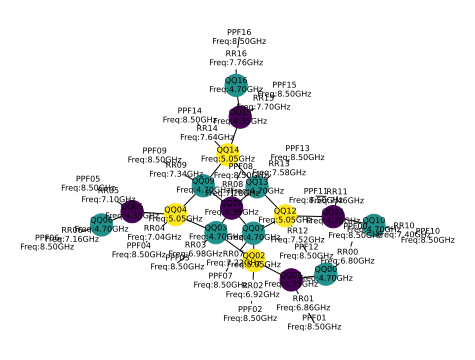

In [46]:
graph = agent.get_rustworkx_graph()
pos = rx.spring_layout(graph, k=0.3, seed = 16)

# get labels from layout
labels = {i: f"{node.type[0].upper()}{node.id}\nFreq:{node.frequency/1e9:.2f}GHz" for i, node in enumerate(layout.nodes)}
colors = [node.color for node in layout.nodes]

def labels_func(node):
    return f"{node.type[0].upper()}{node.id}\nFreq:{node.frequency/1e9:.2f}GHz"

mpl_draw(graph, pos= pos, with_labels=True, labels=labels_func, node_size=500, font_size=8, node_color= colors)

## Interaction management

Efficent agent operation may require the user to keep track of the token size, especia;lly as the history grows. The user may at any m,oemnt use the model's native capabilities to calculate number of tokens or price for queries (these may vary from model to model), and may use helper fucntions from the qfoundry.agent to for example reset hsitory to a previous checkpoint.

In [55]:
prompt = agent._last_query_
response = agent._last_response_

ntok_prompt = agent.client.count_tokens(prompt)
ntok_response = agent.client.count_tokens(response)

if agent.client.model_name == "models/gemini-3-pro-preview":
        price_prompt_token = 2 if ntok_prompt.total_tokens > 200e3 else 4 # price per million tokens in USD
        price_response_token = 16 if ntok_response.total_tokens > 200e3 else 32 # price per million tokens in USD
elif agent.client.model_name == "models/gemini-2.5-flash":
        price_prompt_token = 0.3
        price_response_token = 2.5
else:
        raise ValueError(f"Unknown model for pricing: {agent.client.model_name}")

print(f'Last query price using {agent.client.model_name}: {round((ntok_prompt.total_tokens/1e6*price_prompt_token + ntok_response.total_tokens/1e6*price_response_token)*100, 2)} US cents')

Last query price using models/gemini-2.5-flash: 2.04 US cents
